# Denoising

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

Choosing dataset and noise type

In [4]:
DATASET = 'CIFAR10'   # options: 'MNIST', 'CIFAR10'
NOISE_TYPE = 'salt_pepper'  # options: 'gaussian', 'salt_pepper', 'speckle'

Loading and preprocessing the dataset

In [6]:
def load_dataset(name='CIFAR10'):

    if name.upper() == 'MNIST':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train = x_train[..., np.newaxis]
        x_test  = x_test[..., np.newaxis]
    elif name.upper() == 'CIFAR10':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    else:
        raise ValueError("Unsupported dataset. Please choose 'MNIST' or 'CIFAR10'.")
    x_train = x_train.astype('float32') / 255.
    x_test  = x_test.astype('float32')  / 255.
    return (x_train, y_train), (x_test, y_test)

Adding noise

In [8]:
def add_gaussian_noise(images, noise_factor=0.5):
    """
    Add Gaussian noise with specified noise_factor.
    """
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

def add_salt_pepper_noise(images, prob=0.05):
    """
    Add salt & pepper noise with probability `prob`.
    """
    noisy = images.copy()
    # Salt & pepper mask
    salt_pepper_mask = np.random.choice([0, 1, 2], size=images.shape, p=[prob/2, prob/2, 1-prob])
    noisy[salt_pepper_mask == 0] = 0.0  # Pepper
    noisy[salt_pepper_mask == 1] = 1.0  # Salt
    return np.clip(noisy, 0., 1.)

def add_speckle_noise(images):
    """
    Add speckle noise: output = image + image * noise
    """
    noise = np.random.randn(*images.shape)
    noisy = images + images * noise
    return np.clip(noisy, 0., 1.)

def add_noise(images, noise_type='salt_pepper'):
    """
    Wrapper to apply different noise types.
    """
    if noise_type == 'gaussian':
        return add_gaussian_noise(images, noise_factor=0.5)
    elif noise_type == 'salt_pepper':
        return add_salt_pepper_noise(images, prob=0.1)
    elif noise_type == 'speckle':
        return add_speckle_noise(images)
    else:
        raise ValueError("Unsupported noise type. Choose 'gaussian', 'salt_pepper', or 'speckle'.")

Defining and training autoencoder

In [10]:
def build_autoencoder(input_shape):
    from tensorflow.keras import layers, models
    inputs = tf.keras.Input(shape=input_shape)  # e.g., (28,28,1) or (32,32,3)

    # Encoder
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    
    # Bottleneck
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    
    channels = input_shape[-1]
    outputs = layers.Conv2D(channels, (3,3), activation='sigmoid', padding='same')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

Gaussian filter

In [12]:
def gaussian_filter_denoise(img, kernel_size=3):
    """
    Apply Gaussian blur to a single image (or multi-channel).
    """
    if len(img.shape) == 3 and img.shape[-1] == 3:
        # For color images
        denoised = []
        for c in range(3):
            channel_255 = (img[..., c] * 255).astype(np.uint8)
            blurred = cv2.GaussianBlur(channel_255, (kernel_size, kernel_size), 0)
            denoised.append(blurred.astype(np.float32) / 255.)
        denoised = np.stack(denoised, axis=-1)
    else:
        # Grayscale
        channel_255 = (img[..., 0] * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(channel_255, (kernel_size, kernel_size), 0)
        denoised = blurred.astype(np.float32) / 255.
        denoised = denoised[..., np.newaxis]
    return denoised

def batch_gaussian_denoise(images, kernel_size=3):
    denoised_imgs = []
    for i in range(images.shape[0]):
        denoised_imgs.append(gaussian_filter_denoise(images[i], kernel_size=kernel_size))
    return np.array(denoised_imgs)

MSE, PSNR

In [14]:
def mse(img1, img2):
    return np.mean((img1 - img2)**2)

def psnr(img1, img2):
    mse_val = mse(img1, img2)
    if mse_val == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse_val))

In [15]:
def main():
    # 1) Load dataset
    (x_train, _), (x_test, _) = load_dataset(DATASET)
    input_shape = x_train.shape[1:]  # e.g., (28,28,1) or (32,32,3)

    # 2) Create noisy data
    x_train_noisy = add_noise(x_train, noise_type=NOISE_TYPE)
    x_test_noisy  = add_noise(x_test,  noise_type=NOISE_TYPE)

    # 3) Build autoencoder
    autoencoder = build_autoencoder(input_shape)
    autoencoder.summary()

    # 4) Train autoencoder
    EPOCHS = 15
    BATCH_SIZE = 128

    autoencoder.fit(
        x_train_noisy, x_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(x_test_noisy, x_test)
    )

    # 5) Denoise using the trained autoencoder
    decoded_test = autoencoder.predict(x_test_noisy)

    # 6) Denoise using Gaussian filter as baseline
    x_test_gaussian = batch_gaussian_denoise(x_test_noisy, kernel_size=3)

    # 7) Evaluate Performance
    auto_psnr_list = []
    gauss_psnr_list = []

    for i in range(len(x_test)):
        auto_psnr_list.append(psnr(x_test[i], decoded_test[i]))
        gauss_psnr_list.append(psnr(x_test[i], x_test_gaussian[i]))

    print(f"Dataset = {DATASET}, Noise = {NOISE_TYPE}")
    print("Autoencoder PSNR: ", np.mean(auto_psnr_list))
    print("Gaussian PSNR: ", np.mean(gauss_psnr_list))

    # 8) Visual Comparison
    n = 5  # number of images to visualize
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Original (noisy)
        ax = plt.subplot(3, n, i+1)
        plt.imshow(x_test_noisy[i].squeeze(), cmap='gray' if input_shape[-1] == 1 else None)
        ax.set_title("Noisy")
        ax.axis('off')

        # Autoencoder
        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(decoded_test[i].squeeze(), cmap='gray' if input_shape[-1] == 1 else None)
        ax.set_title("Autoencoder")
        ax.axis('off')

        # Gaussian
        ax = plt.subplot(3, n, i+1+2*n)
        plt.imshow(x_test_gaussian[i].squeeze(), cmap='gray' if input_shape[-1] == 1 else None)
        ax.set_title("Gaussian")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - loss: 0.5975 - val_loss: 0.5665
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - loss: 0.5657 - val_loss: 0.5643
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - loss: 0.5630 - val_loss: 0.5637
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - loss: 0.5617 - val_loss: 0.5610
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - loss: 0.5602 - val_loss: 0.5602
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 245ms/step - loss: 0.5589 - val_loss: 0.5593
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 226ms/step - loss: 0.5589 - val_loss: 0.5596
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - loss: 0.5581 - val_loss: 0.5585
Epoch 9/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - loss: 0.5582 - val_loss: 0.5583
Epoch 10/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 211ms/step - loss: 0.5569 - val_loss: 0.5584
Epoch 11/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - loss: 0.5570 - val_loss: 0.5572
Epoch 12/15
391/391 ━

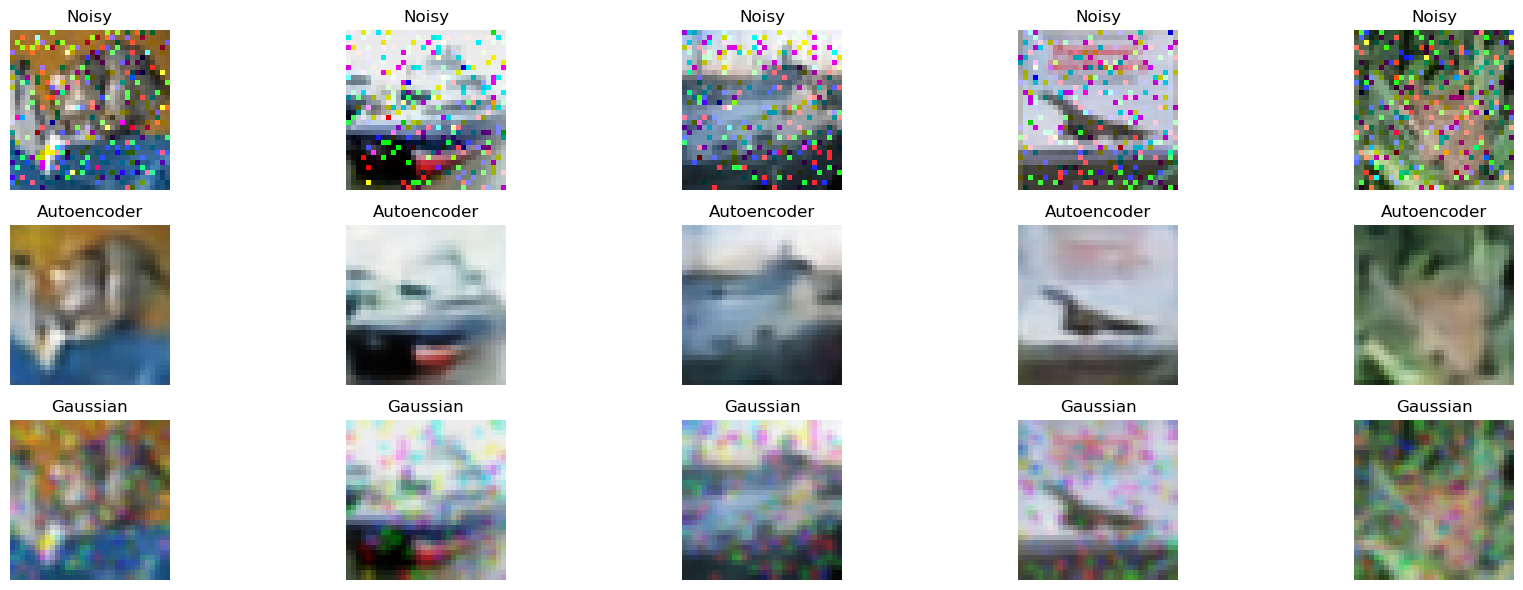

In [16]:
if __name__ == "__main__":
    main()